In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import time
import joblib
import gc
from lb2jpsil import fit_utils
from scipy import optimize, integrate
from sklearn import metrics
import pylab

# Import data

In [2]:
inputData = '~/data/Custom_2e7_LHCbData_2016-17-18_MagUpDown_Dimuon_Ttracks.h5'

In [3]:
tickData = time.perf_counter()
df_Data = pd.read_hdf(inputData, key='LHCbData')
tockData = time.perf_counter()
print(f"Data imported in {tockData - tickData:0.4f} seconds.")
df_Data

Data imported found in 36.3094 seconds.


,Lb_ENDVERTEX_X,Lb_ENDVERTEX_Y,Lb_ENDVERTEX_Z,L_ENDVERTEX_X,L_ENDVERTEX_Y,L_ENDVERTEX_Z,Jpsi_ENDVERTEX_X,Jpsi_ENDVERTEX_Y,Jpsi_ENDVERTEX_Z,L_PX,...,DTF_FixJPsiLambda_pim_PZ,DTF_FixJPsiLambda_p_PX,DTF_FixJPsiLambda_p_PY,DTF_FixJPsiLambda_p_PZ,DTF_FixJPsiLambda_mum_PX,DTF_FixJPsiLambda_mum_PY,DTF_FixJPsiLambda_mum_PZ,DTF_FixJPsiLambda_mup_PX,DTF_FixJPsiLambda_mup_PY,DTF_FixJPsiLambda_mup_PZ
0,0.632911,0.178342,5.049691,-255.844345,-56.212456,5932.708984,0.6329,0.1792,5.047500,-2260.323975,...,6914.724609,-1747.009033,-350.620087,4.244350e+04,-793.366150,54.107079,4428.827637,551.944824,-1187.755859,58498.097656
1,0.819310,-0.207494,-12.258046,-82.289032,-16.596403,6057.988770,0.8168,-0.2077,-12.286400,-1174.547974,...,-438873.187500,17554.949219,-1689.618530,-1.096748e+06,-671.020935,-172.458801,11034.705078,3482.218506,-316.173492,44959.343750
2,0.839784,-0.138968,5.569199,110.246147,-332.334747,7637.261719,0.8398,-0.1389,5.569000,238.606934,...,3323.346436,288.640503,-601.730591,1.581895e+04,-354.302216,850.272766,4830.386719,-2323.214111,-2683.439209,16002.040039
3,0.974854,-0.085595,20.542496,-32.013988,97.482521,6381.826660,0.9740,-0.0862,20.537600,-520.050232,...,4444.798828,86.225441,69.312088,9.542386e+03,1987.955200,506.320618,31560.458984,3073.743896,855.267761,15493.315430
4,0.915558,-0.309900,-33.831448,-129.211182,-8.126650,7658.323242,0.9167,-0.3099,-33.824600,-1304.095825,...,10141.857422,-1597.443848,-59.996716,9.855463e+04,-1009.855408,-946.313660,13937.730469,2257.919922,-1761.619263,39306.191406
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19999995,0.956132,-0.172210,3.714052,49.854134,-73.864464,6874.567871,0.9557,-0.1730,3.717600,129.978653,...,4102.897949,68.620247,-245.701263,1.517294e+04,1200.822266,-613.330017,20430.341797,-1562.266357,-704.328369,10431.737305
19999996,0.305030,0.413220,-42.250729,-87.392105,143.684814,7808.419434,0.3054,0.4132,-42.252998,-389.793945,...,46724.847656,-4340.386719,6602.253906,3.538179e+05,-2404.630127,-454.848511,23270.675781,-743.044434,2128.313965,18170.177734
19999997,0.769589,-0.154897,-25.393505,118.406548,319.421661,7314.084961,0.7696,-0.1549,-25.393499,809.060486,...,7479.251953,473.056091,1122.487549,2.563020e+04,328.308044,-1677.067383,26614.564453,-525.675964,-5430.585938,33161.121094
19999998,0.811096,-0.118911,23.607960,-133.969757,9.905499,7684.147461,0.8094,-0.1188,23.603701,-787.944824,...,84981.585938,-1313.759766,149.591324,5.813398e+04,-950.303467,737.577881,13734.229492,787.927246,-1978.893799,24771.326172


## Integrate missing features

In [4]:
def MomentumModulus(px, py, pz):
    return np.sqrt(px**2 + py**2 + pz**2)

def TransverseMomentumModulus(px, py):
    return np.sqrt(px**2 + py**2)

In [5]:
df_Data = df_Data.assign(
    p_PT = TransverseMomentumModulus(df_Data['p_PX'],df_Data['p_PY']),
    DTF_FixJPsi_p_PT = TransverseMomentumModulus(df_Data['DTF_FixJPsi_p_PX'], df_Data['DTF_FixJPsi_p_PY']),
    DTF_FixJPsiLambda_p_PT = TransverseMomentumModulus(df_Data['DTF_FixJPsiLambda_p_PX'], df_Data['DTF_FixJPsiLambda_p_PY']),
    pim_PT = TransverseMomentumModulus(df_Data['pim_PX'],df_Data['pim_PY']),
    DTF_FixJPsi_pim_PT = TransverseMomentumModulus(df_Data['DTF_FixJPsi_pim_PX'], df_Data['DTF_FixJPsi_pim_PY']),
    DTF_FixJPsiLambda_pim_PT = TransverseMomentumModulus(df_Data['DTF_FixJPsiLambda_pim_PX'], df_Data['DTF_FixJPsiLambda_pim_PY']),
    Jpsi_PT = TransverseMomentumModulus(df_Data['Jpsi_PX'],df_Data['Jpsi_PY'])
)

df_Data

,Lb_ENDVERTEX_X,Lb_ENDVERTEX_Y,Lb_ENDVERTEX_Z,L_ENDVERTEX_X,L_ENDVERTEX_Y,L_ENDVERTEX_Z,Jpsi_ENDVERTEX_X,Jpsi_ENDVERTEX_Y,Jpsi_ENDVERTEX_Z,L_PX,...,DTF_FixJPsiLambda_mup_PX,DTF_FixJPsiLambda_mup_PY,DTF_FixJPsiLambda_mup_PZ,p_PT,DTF_FixJPsi_p_PT,DTF_FixJPsiLambda_p_PT,pim_PT,DTF_FixJPsi_pim_PT,DTF_FixJPsiLambda_pim_PT,Jpsi_PT
0,0.632911,0.178342,5.049691,-255.844345,-56.212456,5932.708984,0.6329,0.1792,5.047500,-2260.323975,...,551.944824,-1187.755859,58498.097656,1525.044067,1749.453735,1781.845947,782.852173,321.232666,404.077881,1184.637451
1,0.819310,-0.207494,-12.258046,-82.289032,-16.596403,6057.988770,0.8168,-0.2077,-12.286400,-1174.547974,...,3482.218506,-316.173492,44959.343750,521.194397,1472.479248,17636.072266,350.746094,2199.127930,7932.257812,2890.091064
2,0.839784,-0.138968,5.569199,110.246147,-332.334747,7637.261719,0.8398,-0.1389,5.569000,238.606934,...,-2323.214111,-2683.439209,16002.040039,562.488403,319.403137,667.377747,243.758881,295.576294,217.761917,3125.168213
3,0.974854,-0.085595,20.542496,-32.013988,97.482521,6381.826660,0.9740,-0.0862,20.537600,-520.050232,...,3073.743896,855.267761,15493.315430,1069.337402,333.917267,110.629982,489.308746,321.725708,177.255829,5212.728516
4,0.915558,-0.309900,-33.831448,-129.211182,-8.126650,7658.323242,0.9167,-0.3099,-33.824600,-1304.095825,...,2257.919922,-1761.619263,39306.191406,1070.575562,816.604553,1598.570068,239.489670,241.753296,242.498489,2975.557373
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19999995,0.956132,-0.172210,3.714052,49.854134,-73.864464,6874.567871,0.9557,-0.1730,3.717600,129.978653,...,-1562.266357,-704.328369,10431.737305,558.789490,503.682892,255.103607,457.936584,395.976440,67.816971,1419.025879
19999996,0.305030,0.413220,-42.250729,-87.392105,143.684814,7808.419434,0.3054,0.4132,-42.252998,-389.793945,...,-743.044434,2128.313965,18170.177734,679.564819,536.461670,7901.184082,108.959473,111.125244,884.577637,3420.045410
19999997,0.769589,-0.154897,-25.393505,118.406548,319.421661,7314.084961,0.7696,-0.1549,-25.393499,809.060486,...,-525.675964,-5430.585938,33161.121094,1938.987793,1319.760986,1218.096924,347.455963,356.902771,326.465515,6959.143066
19999998,0.811096,-0.118911,23.607960,-133.969757,9.905499,7684.147461,0.8094,-0.1188,23.603701,-787.944824,...,787.927246,-1978.893799,24771.326172,478.574829,365.358093,1322.249023,311.696259,457.698700,1242.788208,1240.753418


In [6]:
successDictionaryReverse = {
    'Success': 0.0,
    'Failed': 1.0,
    'NonConverged': 3.0
}

df_Data.replace({'DTF_FixJPsi_status': successDictionaryReverse}, inplace=True)
df_Data.replace({'DTF_FixJPsiLambda_status': successDictionaryReverse}, inplace=True)
df_Data

,Lb_ENDVERTEX_X,Lb_ENDVERTEX_Y,Lb_ENDVERTEX_Z,L_ENDVERTEX_X,L_ENDVERTEX_Y,L_ENDVERTEX_Z,Jpsi_ENDVERTEX_X,Jpsi_ENDVERTEX_Y,Jpsi_ENDVERTEX_Z,L_PX,...,DTF_FixJPsiLambda_mup_PX,DTF_FixJPsiLambda_mup_PY,DTF_FixJPsiLambda_mup_PZ,p_PT,DTF_FixJPsi_p_PT,DTF_FixJPsiLambda_p_PT,pim_PT,DTF_FixJPsi_pim_PT,DTF_FixJPsiLambda_pim_PT,Jpsi_PT
0,0.632911,0.178342,5.049691,-255.844345,-56.212456,5932.708984,0.6329,0.1792,5.047500,-2260.323975,...,551.944824,-1187.755859,58498.097656,1525.044067,1749.453735,1781.845947,782.852173,321.232666,404.077881,1184.637451
1,0.819310,-0.207494,-12.258046,-82.289032,-16.596403,6057.988770,0.8168,-0.2077,-12.286400,-1174.547974,...,3482.218506,-316.173492,44959.343750,521.194397,1472.479248,17636.072266,350.746094,2199.127930,7932.257812,2890.091064
2,0.839784,-0.138968,5.569199,110.246147,-332.334747,7637.261719,0.8398,-0.1389,5.569000,238.606934,...,-2323.214111,-2683.439209,16002.040039,562.488403,319.403137,667.377747,243.758881,295.576294,217.761917,3125.168213
3,0.974854,-0.085595,20.542496,-32.013988,97.482521,6381.826660,0.9740,-0.0862,20.537600,-520.050232,...,3073.743896,855.267761,15493.315430,1069.337402,333.917267,110.629982,489.308746,321.725708,177.255829,5212.728516
4,0.915558,-0.309900,-33.831448,-129.211182,-8.126650,7658.323242,0.9167,-0.3099,-33.824600,-1304.095825,...,2257.919922,-1761.619263,39306.191406,1070.575562,816.604553,1598.570068,239.489670,241.753296,242.498489,2975.557373
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19999995,0.956132,-0.172210,3.714052,49.854134,-73.864464,6874.567871,0.9557,-0.1730,3.717600,129.978653,...,-1562.266357,-704.328369,10431.737305,558.789490,503.682892,255.103607,457.936584,395.976440,67.816971,1419.025879
19999996,0.305030,0.413220,-42.250729,-87.392105,143.684814,7808.419434,0.3054,0.4132,-42.252998,-389.793945,...,-743.044434,2128.313965,18170.177734,679.564819,536.461670,7901.184082,108.959473,111.125244,884.577637,3420.045410
19999997,0.769589,-0.154897,-25.393505,118.406548,319.421661,7314.084961,0.7696,-0.1549,-25.393499,809.060486,...,-525.675964,-5430.585938,33161.121094,1938.987793,1319.760986,1218.096924,347.455963,356.902771,326.465515,6959.143066
19999998,0.811096,-0.118911,23.607960,-133.969757,9.905499,7684.147461,0.8094,-0.1188,23.603701,-787.944824,...,787.927246,-1978.893799,24771.326172,478.574829,365.358093,1322.249023,311.696259,457.698700,1242.788208,1240.753418


# Import BDT
Using VF BDT for now.

In [7]:
daughterMomenta = 'VF'
BDTSavedStatePath = 'saved_states/BDT_VF_0.05_4_3_1000_0.7.joblib'

tickBDTImport = time.perf_counter()
BDT = joblib.load(BDTSavedStatePath)
tockBDTImport = time.perf_counter()
print(f"BDT imported in {(tockBDTImport - tickBDTImport):0.4f} seconds.")

BDT imported in 0.1379 seconds.


In [8]:
if daughterMomenta == 'VF':
    pMomenta = ['p_PT', 'p_PZ']
    pimMomenta = ['pim_PT', 'pim_PZ']
elif daughterMomenta == 'DTF':
    pMomenta = ['DTF_FixJPsi_p_PT', 'DTF_FixJPsi_p_PZ']
    pimMomenta = ['DTF_FixJPsi_pim_PT', 'DTF_FixJPsi_pim_PZ']
elif daughterMomenta == 'DTFL':
    pMomenta = ['DTF_FixJPsiLambda_p_PT', 'DTF_FixJPsiLambda_p_PZ']
    pimMomenta = ['DTF_FixJPsiLambda_pim_PT', 'DTF_FixJPsiLambda_pim_PZ']
elif daughterMomenta == 'NO':
    pMomenta = []
    pimMomenta = []
else:
    raise ValueError(daughterMomenta + " is not a valid option for momenta usage.")

In [9]:
fixedFeatures = [
    'Jpsi_PT',
    'Jpsi_PZ',
    'L_ENDVERTEX_X',
    'L_ENDVERTEX_Y',
    'L_ENDVERTEX_Z',
    'L_BPVDIRA',
    'Lb_BPVDIRA',
    'L_VFASPF_CHI2_VDOF',
    'Lb_VFASPF_CHI2_VDOF',
    'L_BPVIPCHI2',
    'Lb_BPVIPCHI2',
    'L_BPVVDCHI2',
    'Lb_BPVVDCHI2',
    'DTF_FixJPsi_status',
    'DTF_FixJPsiLambda_status'
]

In [10]:
features = pMomenta + pimMomenta + fixedFeatures

In [11]:
X_predict = df_Data.loc[:, features].to_numpy()
X_predict

array([[1.52504407e+03, 4.53043789e+04, 7.82852173e+02, ...,
        9.53415405e+02, 0.00000000e+00, 0.00000000e+00],
       [5.21194397e+02, 3.18203027e+04, 3.50746094e+02, ...,
        5.21637917e+01, 0.00000000e+00, 1.00000000e+00],
       [5.62488403e+02, 1.24465469e+04, 2.43758881e+02, ...,
        1.30287647e+01, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.93898779e+03, 3.84780352e+04, 3.47455963e+02, ...,
        1.37913008e+01, 0.00000000e+00, 0.00000000e+00],
       [4.78574829e+02, 2.26745801e+04, 3.11696259e+02, ...,
        6.70280685e+01, 0.00000000e+00, 1.00000000e+00],
       [6.44154724e+02, 3.28202500e+04, 3.11696259e+02, ...,
        6.67095490e+01, 0.00000000e+00, 1.00000000e+00]])

In [12]:
tickBDTPredict = time.perf_counter()
Y_proba_predicted = BDT.predict_proba(X_predict)[:,1]
tockBDTPredict = time.perf_counter()
print(f"BDT imported in {(tockBDTPredict - tickBDTPredict):0.4f} seconds.")

BDT imported in 347.5347 seconds.


In [13]:
Y_proba_predicted

array([9.95874495e-03, 7.62024690e-05, 5.81133729e-03, ...,
       6.16155834e-01, 2.14231625e-03, 5.24180048e-03])

In [14]:
df_Data = df_Data.assign(
    BDT_output = Y_proba_predicted,
)

df_Data

,Lb_ENDVERTEX_X,Lb_ENDVERTEX_Y,Lb_ENDVERTEX_Z,L_ENDVERTEX_X,L_ENDVERTEX_Y,L_ENDVERTEX_Z,Jpsi_ENDVERTEX_X,Jpsi_ENDVERTEX_Y,Jpsi_ENDVERTEX_Z,L_PX,...,DTF_FixJPsiLambda_mup_PY,DTF_FixJPsiLambda_mup_PZ,p_PT,DTF_FixJPsi_p_PT,DTF_FixJPsiLambda_p_PT,pim_PT,DTF_FixJPsi_pim_PT,DTF_FixJPsiLambda_pim_PT,Jpsi_PT,BDT_output
0,0.632911,0.178342,5.049691,-255.844345,-56.212456,5932.708984,0.6329,0.1792,5.047500,-2260.323975,...,-1187.755859,58498.097656,1525.044067,1749.453735,1781.845947,782.852173,321.232666,404.077881,1184.637451,0.009959
1,0.819310,-0.207494,-12.258046,-82.289032,-16.596403,6057.988770,0.8168,-0.2077,-12.286400,-1174.547974,...,-316.173492,44959.343750,521.194397,1472.479248,17636.072266,350.746094,2199.127930,7932.257812,2890.091064,0.000076
2,0.839784,-0.138968,5.569199,110.246147,-332.334747,7637.261719,0.8398,-0.1389,5.569000,238.606934,...,-2683.439209,16002.040039,562.488403,319.403137,667.377747,243.758881,295.576294,217.761917,3125.168213,0.005811
3,0.974854,-0.085595,20.542496,-32.013988,97.482521,6381.826660,0.9740,-0.0862,20.537600,-520.050232,...,855.267761,15493.315430,1069.337402,333.917267,110.629982,489.308746,321.725708,177.255829,5212.728516,0.000470
4,0.915558,-0.309900,-33.831448,-129.211182,-8.126650,7658.323242,0.9167,-0.3099,-33.824600,-1304.095825,...,-1761.619263,39306.191406,1070.575562,816.604553,1598.570068,239.489670,241.753296,242.498489,2975.557373,0.821073
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19999995,0.956132,-0.172210,3.714052,49.854134,-73.864464,6874.567871,0.9557,-0.1730,3.717600,129.978653,...,-704.328369,10431.737305,558.789490,503.682892,255.103607,457.936584,395.976440,67.816971,1419.025879,0.003192
19999996,0.305030,0.413220,-42.250729,-87.392105,143.684814,7808.419434,0.3054,0.4132,-42.252998,-389.793945,...,2128.313965,18170.177734,679.564819,536.461670,7901.184082,108.959473,111.125244,884.577637,3420.045410,0.001618
19999997,0.769589,-0.154897,-25.393505,118.406548,319.421661,7314.084961,0.7696,-0.1549,-25.393499,809.060486,...,-5430.585938,33161.121094,1938.987793,1319.760986,1218.096924,347.455963,356.902771,326.465515,6959.143066,0.616156
19999998,0.811096,-0.118911,23.607960,-133.969757,9.905499,7684.147461,0.8094,-0.1188,23.603701,-787.944824,...,-1978.893799,24771.326172,478.574829,365.358093,1322.249023,311.696259,457.698700,1242.788208,1240.753418,0.002142


In [15]:
del(Y_proba_predicted)
gc.collect()

0

# Explore selected results

In [16]:
plum = '#6e304b'
apricot = '#e2ae6c'
threshold = 0.7 # 0.88

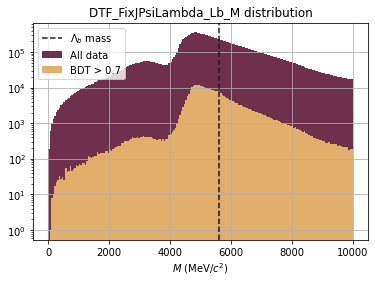

In [17]:
massToPlot = 'DTF_FixJPsiLambda_Lb_M'
massRange = (0, 10000)

plt.hist(df_Data[massToPlot],bins=200,
         range=massRange, color=plum, alpha=1, label="All data", density=False)
plt.hist(df_Data.loc[df_Data['BDT_output'] > threshold, massToPlot],bins=200,
         range=massRange, color=apricot, alpha=1, label="BDT > " + str(threshold), density=False)
plt.grid()
plt.yscale('log')
plt.xlabel("$M$ (MeV/$c^2$)")
plt.title(massToPlot + " distribution")
plt.axvline(5620.2, color='#22161c', linestyle='--', label='$\Lambda_b$ mass')
plt.legend()
plt.show()

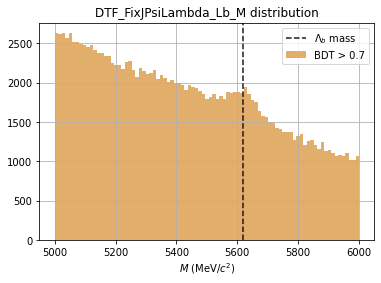

In [18]:
data, bins, patches = plt.hist(df_Data.loc[df_Data['BDT_output'] > threshold, massToPlot],bins=87,
         range=(5000,6000), color=apricot, alpha=1, label="BDT > " + str(threshold), density=False)
plt.grid()
#plt.yscale('log')
plt.xlabel("$M$ (MeV/$c^2$)")
plt.title(massToPlot + " distribution")
plt.axvline(5620.2, color='#22161c', linestyle='--', label='$\Lambda_b$ mass')
plt.legend()
plt.show()

# Preliminary signal + background fit

In [19]:
binsMidpoints = (bins[1:] + bins[:-1]) / 2

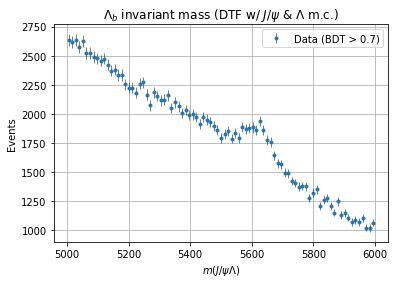

In [20]:
plt.errorbar(binsMidpoints,
             data,np.sqrt(data),
             linestyle='',
             marker='.',
             ecolor='k',
             elinewidth=0.5,
             label='Data (BDT > ' + str(threshold) + ")")
plt.grid()
plt.title("$\Lambda_b$ invariant mass (DTF w/ $J/\psi$ & $\Lambda$ m.c.)")
plt.xlabel("$m(J/\psi \Lambda)$")
plt.ylabel("Events")
plt.legend()
plt.show()

In [21]:
## This is the fit function, sum of:
## 1. A crystal_ball_double_norm with fixed parameters apart from normalization S (derived from data fit).
## 2. A turn_on_exp with free parameters C (normalization), m_0 (turn-on mass), a (coefficient, as in exp[-a*x])
def InvariantMassFitFunction(x, S, C, m0, a):
    ## Fixed parameters
    mu = 5618.8
    sigma = 35
    alpha1=0.88
    n1=2.7
    alpha2=1.00
    n2=2.6
    
    signal = fit_utils.crystal_ball_double_norm(x, S, mu, sigma, alpha1, n1, alpha2, n2)
    background = fit_utils.turn_on_exp(x, C, m0, a)
    
    return signal + background

In [22]:
## Almost zero, but not quite
epsilon = 1e-15

## Double crystal ball parameter dictionary
signalFunctionDictionary = {
     'param_names' : [ r'S' ],
     'p0'          : [  200 ],
     'lb'          : [    0 ],
     'ub'          : [  1e9 ]
}

backgroundFunctionDictionary = {
    'param_names' : [r'C',    r'm_0', r'a'],
    'p0' :          [0.09,    3500,   0.0008 ],
    'lb' :          [epsilon, 0,      epsilon],
    'ub' :          [1e9,     4999,   1      ]
}

In [23]:
bestParameters, covarianceMatrix = optimize.curve_fit(
    f=InvariantMassFitFunction,
    xdata=binsMidpoints,
    ydata=data,
    p0=signalFunctionDictionary['p0']+backgroundFunctionDictionary['p0'],
    sigma=np.sqrt(data),
    bounds=(
        signalFunctionDictionary['lb']+backgroundFunctionDictionary['lb'],
        signalFunctionDictionary['ub']+backgroundFunctionDictionary['ub']
    )
)

In [24]:
parameterNames = signalFunctionDictionary['param_names'] + backgroundFunctionDictionary['param_names']
bestParametersErrors = np.sqrt(np.diag(covarianceMatrix))
for name, bestValue, error in zip(parameterNames, bestParameters, bestParametersErrors):
    print(name, ":", bestValue, "+-", error)

S : 50459.2447255718 +- 2871.6594099701806
C : 243.13198819169762 +- 3.1672924335848136
m_0 : 4565.106587752154 +- 39.98141423732257
a : 0.0015326955150880728 +- 3.0648840723754085e-05


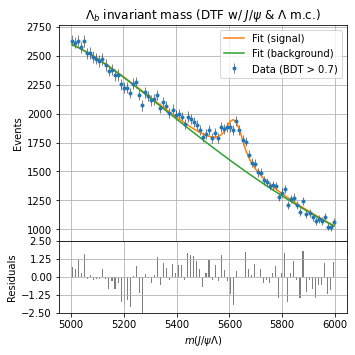

In [25]:
fig1 = plt.figure(figsize=(5, 5))

frame1=fig1.add_axes((.1,.3,.8,.6))
plt.errorbar(binsMidpoints,data,np.sqrt(data), linestyle='', marker='.',
             color='tab:blue', ecolor='k', elinewidth=0.5, label='Data (BDT > ' + str(threshold) + ")")
plt.plot(binsMidpoints, InvariantMassFitFunction(binsMidpoints, *bestParameters), color='tab:orange', label='Fit (signal)')
plt.plot(binsMidpoints, fit_utils.turn_on_exp(binsMidpoints, *bestParameters[1:]), color='tab:green', label='Fit (background)')
plt.grid()
plt.title("$\Lambda_b$ invariant mass (DTF w/ $J/\psi$ & $\Lambda$ m.c.)")
plt.xlabel("$m(J/\psi \Lambda)$")
plt.ylabel("Events")
plt.legend()

frame2=fig1.add_axes((.1,.1,.8,.2))
plt.bar(binsMidpoints, (data - InvariantMassFitFunction(binsMidpoints, *bestParameters))/np.sqrt(data),
        width=4, color='tab:gray')
plt.ylim((-2.5,2.5))
plt.grid()
plt.xlabel("$m(J/\psi \Lambda)$")
plt.ylabel("Residuals")
plt.yticks([-2.5,-1.25,0,1.25,2.5])
plt.show()

# Integrate to extract $s_0$ and $b_0$

In [26]:
mu = 5618.8
sigma = 35
alpha1=0.88
n1=2.7
alpha2=1.00
n2=2.6

S, C, m0, a = bestParameters

lowerLimit = mu - 2.5*sigma
upperLimit = mu + 2.5*sigma

print("Integration interval:", (lowerLimit, upperLimit))

Integration interval: (5531.3, 5706.3)


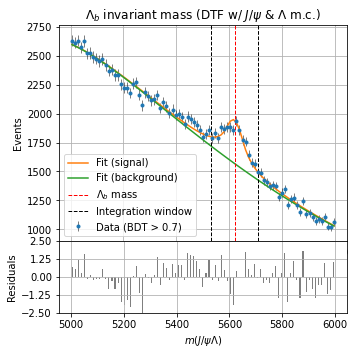

In [27]:
fig1 = plt.figure(figsize=(5, 5))

frame1=fig1.add_axes((.1,.3,.8,.6))
plt.errorbar(binsMidpoints,data,np.sqrt(data), linestyle='', marker='.',
             color='tab:blue', ecolor='k', elinewidth=0.5, label='Data (BDT > ' + str(threshold) + ")")
plt.plot(binsMidpoints, InvariantMassFitFunction(binsMidpoints, *bestParameters), color='tab:orange', label='Fit (signal)')
plt.plot(binsMidpoints, fit_utils.turn_on_exp(binsMidpoints, *bestParameters[1:]), color='tab:green', label='Fit (background)')
plt.grid()
plt.title("$\Lambda_b$ invariant mass (DTF w/ $J/\psi$ & $\Lambda$ m.c.)")
plt.xlabel("$m(J/\psi \Lambda)$")
plt.ylabel("Events")
plt.axvline(5620.2, linestyle='--', color='r', linewidth=1, label='$\Lambda_b$ mass')
plt.axvline(lowerLimit, linestyle='--', color='k', linewidth=1)
plt.axvline(upperLimit, linestyle='--', color='k', linewidth=1, label='Integration window')
plt.legend()

frame2=fig1.add_axes((.1,.1,.8,.2))
plt.bar(binsMidpoints, (data - InvariantMassFitFunction(binsMidpoints, *bestParameters))/np.sqrt(data),
        width=4, color='tab:gray')
plt.ylim((-2.5,2.5))
plt.grid()
plt.xlabel("$m(J/\psi \Lambda)$")
plt.ylabel("Residuals")
plt.yticks([-2.5,-1.25,0,1.25,2.5])
plt.show()

In [28]:
condition = (binsMidpoints > lowerLimit) & (binsMidpoints < upperLimit)
newBinsMidpoints = binsMidpoints[condition]
newData = data[condition]
sum(newData)

26910.0

In [29]:
s0 = sum(fit_utils.crystal_ball_double_norm(newBinsMidpoints, S, mu, sigma, alpha1, n1, alpha2, n2))
b0 = sum(fit_utils.turn_on_exp(newBinsMidpoints, C, m0, a))

In [30]:
print("s0 =", s0, "\nb0 =", b0)

s0 = 3153.233985900879 
b0 = 23661.000366210938


In [31]:
inputTest = '~/classifier-studies/data/testData.h5'
df_test = pd.read_hdf(inputTest, 'LHCb_Test')

In [32]:
X_test = df_test.loc[:, features].to_numpy()
Y_test = df_test.loc[:, 'TYPE'].to_numpy()

In [33]:
Y_test_predicted = BDT.predict(X_test)
Y_test_proba_predicted = BDT.predict_proba(X_test)[:,1]

In [34]:
falsePositiveRates_Test, truePositiveRates_Test, thresholds_Test = metrics.roc_curve(Y_test, Y_test_proba_predicted)

In [35]:
df_Test_ThresholdEfficiencies = pd.DataFrame(
    {
        'threshold': thresholds_Test,
        'sig_eff': truePositiveRates_Test,
        'bkg_eff': falsePositiveRates_Test
    }
)

df_Test_ThresholdEfficiencies.sort_values(by='threshold', inplace=True)

In [36]:
df_Test_ThresholdEfficiencies

,threshold,sig_eff,bkg_eff
1348,0.000009,1.000000,1.000000
1347,0.000140,1.000000,0.959635
1346,0.000140,0.999876,0.959635
1345,0.003082,0.999876,0.457874
1344,0.003083,0.999752,0.457874
...,...,...,...
4,0.997074,0.213799,0.000173
3,0.997075,0.213799,0.000115
2,0.999995,0.000000,0.000115
1,1.000000,0.000000,0.000058


In [37]:
closestEfficiencies = df_Test_ThresholdEfficiencies.iloc[
    (df_Test_ThresholdEfficiencies['threshold']-threshold).abs().argsort()[:1]
].to_numpy()[0]

signalReverseEfficiency = closestEfficiencies[1]
backgroundReverseEfficiency = closestEfficiencies[2]

In [38]:
def SignalEfficiency(s0, b0):
    return s0 / np.sqrt(s0 + b0)

In [39]:
df_Test_ThresholdEfficiencies = df_Test_ThresholdEfficiencies.assign(
    sig_events = s0 * df_Test_ThresholdEfficiencies['sig_eff'] / signalReverseEfficiency,
    bkg_events = b0 * df_Test_ThresholdEfficiencies['bkg_eff'] / backgroundReverseEfficiency
)

df_Test_ThresholdEfficiencies = df_Test_ThresholdEfficiencies.assign(
    sig_significance = SignalEfficiency(df_Test_ThresholdEfficiencies['sig_events'], df_Test_ThresholdEfficiencies['bkg_events'])
)

df_Test_ThresholdEfficiencies

,threshold,sig_eff,bkg_eff,sig_events,bkg_events,sig_significance
1348,0.000009,1.000000,1.000000,3464.351928,1.600537e+06,2.735392
1347,0.000140,1.000000,0.959635,3464.351928,1.535932e+06,2.792202
1346,0.000140,0.999876,0.959635,3463.922800,1.535932e+06,2.791856
1345,0.003082,0.999876,0.457874,3463.922800,7.328440e+05,4.036811
1344,0.003083,0.999752,0.457874,3463.493672,7.328440e+05,4.036312
...,...,...,...,...,...,...
4,0.997074,0.213799,0.000173,740.675267,2.772773e+02,23.214753
3,0.997075,0.213799,0.000115,740.675267,1.848516e+02,24.346321
2,0.999995,0.000000,0.000115,0.000000,1.848516e+02,0.000000
1,1.000000,0.000000,0.000058,0.000000,9.242578e+01,0.000000


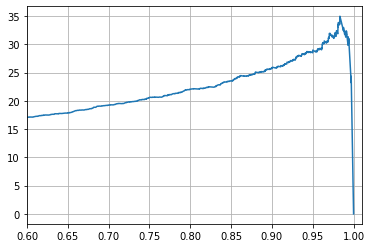

In [40]:
plt.plot(df_Test_ThresholdEfficiencies['threshold'], df_Test_ThresholdEfficiencies['sig_significance'])
plt.xlim(0.6,1.01)
plt.grid()
plt.show()

In [41]:
df_Test_ThresholdEfficiencies.sort_values(by='sig_significance', ascending=False)

,threshold,sig_eff,bkg_eff,sig_events,bkg_events,sig_significance
21,0.983275,0.543664,0.000635,1883.443653,1.016684e+03,34.973903
23,0.983131,0.544779,0.000693,1887.305807,1.109109e+03,34.477938
22,0.983266,0.543664,0.000693,1883.443653,1.109109e+03,34.429578
25,0.983027,0.546513,0.000751,1893.313602,1.201535e+03,34.033204
24,0.983131,0.544779,0.000751,1887.305807,1.201535e+03,33.958187
...,...,...,...,...,...,...
1346,0.000140,0.999876,0.959635,3463.922800,1.535932e+06,2.791856
1348,0.000009,1.000000,1.000000,3464.351928,1.600537e+06,2.735392
2,0.999995,0.000000,0.000115,0.000000,1.848516e+02,0.000000
1,1.000000,0.000000,0.000058,0.000000,9.242578e+01,0.000000


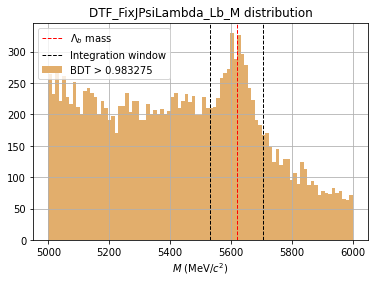

In [47]:
currentThr = 0.983275

data, bins, patches = plt.hist(df_Data.loc[df_Data['BDT_output'] > currentThr, massToPlot],bins=87,
         range=(5000,6000), color=apricot, alpha=1, label="BDT > " + str(currentThr), density=False)
plt.grid()
#plt.yscale('log')
plt.xlabel("$M$ (MeV/$c^2$)")
plt.title(massToPlot + " distribution")
plt.axvline(5620.2, linestyle='--', color='r', linewidth=1, label='$\Lambda_b$ mass')
plt.axvline(lowerLimit, linestyle='--', color='k', linewidth=1)
plt.axvline(upperLimit, linestyle='--', color='k', linewidth=1, label='Integration window')
plt.legend()
plt.show()

In [48]:
bestParameters, covarianceMatrix = optimize.curve_fit(
    f=InvariantMassFitFunction,
    xdata=binsMidpoints,
    ydata=data,
    p0=signalFunctionDictionary['p0']+backgroundFunctionDictionary['p0'],
    sigma=np.sqrt(data),
    bounds=(
        signalFunctionDictionary['lb']+backgroundFunctionDictionary['lb'],
        signalFunctionDictionary['ub']+backgroundFunctionDictionary['ub']
    )
)

In [49]:
parameterNames = signalFunctionDictionary['param_names'] + backgroundFunctionDictionary['param_names']
bestParametersErrors = np.sqrt(np.diag(covarianceMatrix))
for name, bestValue, error in zip(parameterNames, bestParameters, bestParametersErrors):
    print(name, ":", bestValue, "+-", error)

S : 28171.524693290114 +- 1566.214726942793
C : 25.60305033799755 +- 0.7728544784896736
m_0 : 4865.607479329255 +- 33.4980166144729
a : 0.0021905820116844997 +- 9.266334730940257e-05


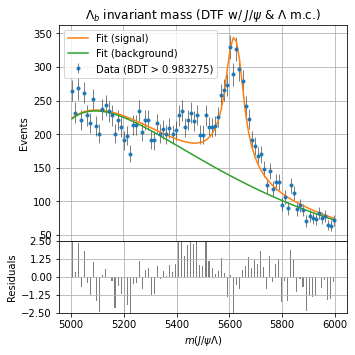

In [50]:
fig1 = plt.figure(figsize=(5, 5))

frame1=fig1.add_axes((.1,.3,.8,.6))
plt.errorbar(binsMidpoints,data,np.sqrt(data), linestyle='', marker='.',
             color='tab:blue', ecolor='k', elinewidth=0.5, label='Data (BDT > ' + str(currentThr) + ")")
plt.plot(binsMidpoints, InvariantMassFitFunction(binsMidpoints, *bestParameters), color='tab:orange', label='Fit (signal)')
plt.plot(binsMidpoints, fit_utils.turn_on_exp(binsMidpoints, *bestParameters[1:]), color='tab:green', label='Fit (background)')
plt.grid()
plt.title("$\Lambda_b$ invariant mass (DTF w/ $J/\psi$ & $\Lambda$ m.c.)")
plt.xlabel("$m(J/\psi \Lambda)$")
plt.ylabel("Events")
plt.legend()

frame2=fig1.add_axes((.1,.1,.8,.2))
plt.bar(binsMidpoints, (data - InvariantMassFitFunction(binsMidpoints, *bestParameters))/np.sqrt(data),
        width=4, color='tab:gray')
plt.ylim((-2.5,2.5))
plt.grid()
plt.xlabel("$m(J/\psi \Lambda)$")
plt.ylabel("Residuals")
plt.yticks([-2.5,-1.25,0,1.25,2.5])
plt.show()

In [46]:
df_Data.loc[(df_Data['BDT_output'] > currentThr) & (df_Data[massToPlot] > lowerLimit) & (df_Data[massToPlot] > upperLimit), massToPlot]

8972         17657.269531
13141        14737.647461
20691       141356.609375
31286        20430.212891
60191         5741.454590
                ...      
19857122     44948.109375
19858022     10193.151367
19907988      9199.267578
19928889     10283.824219
19940073      6921.154297
Name: DTF_FixJPsiLambda_Lb_M, Length: 1516, dtype: float32